# Looking at DR17 RVs
This notebook is designed to look at RVs the DR17 allStar and allVisit file

In [1]:
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table,vstack
import astropy.units as u
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import os.path as path
import numpy as np
from scipy import stats
%matplotlib inline

In [2]:
def exp2h(exps):
    #Scale the hmag based on t = (1 hour)*10^(0.4*(H-11))
    #Take number of 15 minute exposures and convert to H.      
    hmag = 2.5*np.log10(exps/4.0) + 11
    return(hmag)

def h2exp(hmag,sn=100,exptime=15.0):   
    '''
    This function takes in a hmag and given signal to noise and spits back the required time. Based on
    Hmag = 11 at S/N 100 in an hour.
    '''
    #Scale the hmag based on t = (1 hour)*10^(0.4*(H-11))
    #Then I cut it up into 15 minute exposures.      
    time = 60*(sn**2/100.0**2)*10**(0.4*(hmag-11))
    nexp = np.array(np.round(time / exptime)) 
    #Min value is 1
    nexp[(nexp == 0)] = 1
    #Set Nan's to nan  
    nexp[np.isnan(hmag)] = np.nan
    
    #for i in range(len(hmag)):
    #    print(hmag[i],time[i],nexp[i])    
    return(nexp)
def h2sn(hmag,exptime=15.0,zeropoint=11):
    '''
    This function takes in a hmag and given exposure time in minutes. Based on
    Hmag = 11 at S/N 100 in an hour.
    '''
    sn = np.sqrt((exptime/60)*100**2 * 10**(0.4*(zeropoint-hmag)))
    return(sn)
def fit_h2sn(hmag,zeropoint):
    '''
    This function is used to fit the zeropoint of the h2sn fuction. Based on
    Hmag = 11 at S/N 100 in an hour.
    '''
    exptime = 60 
    sn = np.sqrt((exptime/60)*100**2 * 10**(0.4*(zeropoint-hmag)))
    return(sn)

In [3]:
allStar_tab = Table.read('DR17/allStar-dr17-synspec_rev1.fits',hdu=1)
allStar_tab[0:4]

FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,"FPARAM_GRID [21,9]",CHI2_GRID [21],FPARAM [9],"FPARAM_COV [9,9]",ASPCAP_CHI2,PARAM [9],"PARAM_COV [9,9]",PARAMFLAG [9],ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM [27],FELEM_ERR [27],X_H [27],X_H_ERR [27],X_M [27],X_M_ERR [27],ELEM_CHI2 [27],ELEMFRAC [27],ELEMFLAG [27],EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC [27],X_M_SPEC [27],TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,VISIT_PK [100]
bytes64,bytes30,bytes58,bytes71,bytes77,bytes6,int32,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,bytes16,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,int64,int64,bytes256,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int64,int32,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float3

In [4]:
allStar_tab[0]['VISIT_PK']

array([          0,           1, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147

In [5]:
allStar_tab['TELESCOPE'][1]

'apo25m'

## Limit to stars in APOGEE (not 1m)
#Only apo25m data

In [6]:
allStar2_tab = allStar_tab[allStar_tab['TELESCOPE'] == 'apo25m']

 ## Limit to stars with Greater than or equal to 3 visits

In [7]:
allStarSmall_tab = allStar2_tab[(allStar2_tab['NVISITS'] >= 3)]
allStarSmall_tab

FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,"FPARAM_GRID [21,9]",CHI2_GRID [21],FPARAM [9],"FPARAM_COV [9,9]",ASPCAP_CHI2,PARAM [9],"PARAM_COV [9,9]",PARAMFLAG [9],ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM [27],FELEM_ERR [27],X_H [27],X_H_ERR [27],X_M [27],X_M_ERR [27],ELEM_CHI2 [27],ELEMFRAC [27],ELEMFLAG [27],EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC [27],X_M_SPEC [27],TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,VISIT_PK [100]
bytes64,bytes30,bytes58,bytes71,bytes77,bytes6,int32,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,bytes16,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,int64,int64,bytes256,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int64,int32,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float3

## Versus visit SN


In [8]:
allVisit_tab = Table.read('DR17/allVisit-dr17-synspec_rev1.fits',hdu=1)
allVisit_tab

APOGEE_ID,TARGET_ID,VISIT_ID,FILE,FIBERID,CARTID,PLATE,MJD,TELESCOPE,SURVEY,FIELD,PROGRAMNAME,ALT_ID,LOCATION_ID,RA,DEC,GLON,GLAT,RELFLUX,MTPFLUX,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SNR,STARFLAG,STARFLAGS,DATEOBS,JD,VLSR,VGSR,CHISQ,SYNTHFILE,MIN_H,MAX_H,MIN_JK,MAX_JK,VREL,VRELERR,VHELIO,BC,RV_TEFF,RV_LOGG,RV_FEH,RV_CARB,RV_ALPHA,XCORR_VREL,XCORR_VRELERR,XCORR_VHELIO,CCFWHM,AUTOFWHM,RV_CHI2,N_COMPONENTS,RV_COMPONENTS [3],RV_FLAG
bytes23,bytes23,bytes64,bytes45,int16,int16,bytes16,int32,bytes6,bytes14,bytes19,bytes18,bytes47,int16,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,float32,bytes20,float32,bytes17,float32,float32,int32,int32,int32,int32,int32,int32,bytes192,float32,int64,bytes132,bytes23,float64,float32,float32,float32,bytes18,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,int32,float32,int32
VESTA,VESTA,apogee.apo1m.dr17.calibration.56398.VESTA,apVisit-dr17-56398-VESTA.fits,223,0,calibration,56398,apo1m,apo1m,calibration,,,1,-99.9990005493,-99.9990005493,292.21913091040517,-30.60291936369881,nan,nan,99.999,0.0,99.999,0.0,99.999,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,,-9999.99,,-9999.99,-9999.99,0,4194304,0,4194304,0,0,APOGEE_1MTARGET,141.485,0,,2013-04-16T02:57:26.462,2456398.64712,20.779888,-154.51678,2.564746,apg_synthgrid.fits,-9999.99,9999.99,-9999.99,9999.99,18.609097449930392,0.03572344952395425,18.609097449930392,0.0,5980.213304161932,4.643886857731999,-0.20365136898612965,nan,nan,18.609097,0.04114302,18.609097,25.165958,22.851051,1.8802955,1,0.0 .. 0.0,4
VESTA,VESTA,apogee.apo1m.dr17.calibration.56778.VESTA,apVisit-dr17-56778-VESTA.fits,223,0,calibration,56778,apo1m,apo1m,calibration,,,1,-99.9990005493,-99.9990005493,292.21913091040517,-30.60291936369881,nan,nan,99.999,0.0,99.999,0.0,99.999,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,,-9999.99,,-9999.99,-9999.99,0,4194304,0,4194304,0,0,APOGEE_1MTARGET,261.867,0,,2014-05-01T03:54:01.445,2456778.69154,5.7065105,-169.59016,3.7667751,apg_synthgrid.fits,-9999.99,9999.99,-9999.99,9999.99,4.204603375567074,0.019326855430334317,4.204603375567074,0.0,5980.213304161932,4.643886857731999,-0.20365136898612965,nan,nan,4.204603,0.049009245,4.204603,25.060478,22.819765,2.6821659,1,0.0 .. 0.0,4
2M00000002+7417074,2M00000002+7417074,apogee.apo25m.dr17.7545.56936.3,apVisit-dr17-7545-56936-003.fits,3,6,7545,56936,apo25m,apogee2,120+12,disk,none,5046,0.000103,74.285408,119.40180722431822,11.767413541486242,0.942129,0.978529,8.597,0.039,7.667,0.029,7.314,0.018,2MASS,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,7.353,0.02,7.353,0.02,-1,1,-2.8,2.4,UCAC4,0.24235167,RJCE_WISE,0.24235167,0.434002,0,0,-2147465196,0,0,0,"APOGEE2_TWOBIN_GT_0_8,APOGEE2_WISE_DERED,APOGEE2_SHORT,APOGEE2_NORMAL_SAMPLE",368.172,1024,PERSIST_MED,2014-10-06T05:32:14.984,2456936.75399,999999.0,999999.0,0.0,,7.0,12.2,0.8,9999.99,-60.73468752825212,0.021745437779660787,-51.544378003715984,9.190309524536133,3671.8014660312124,1.0904876077781078,-0.40140441709583746,nan,nan,-60.734688,0.008203435,-51.544376,18.920837,16.579477,14.705982,1,0.0 .. 0.0,0
2M00000002+7417074,2M00000002+7417074,apogee.apo25m.dr17.7545.56971.58,apVisit-dr17-7545-56971-05

In [9]:
visit_med_snr_list = list()
for i in range(len(allStarSmall_tab)):
    indices_arr = allStarSmall_tab['VISIT_PK'][i]
    indices_arr = indices_arr[indices_arr != -2147483648]
    visit_med_snr_list.append(np.nanmedian(allVisit_tab['SNR'][indices_arr]))

allStarSmall_tab['VISIT_MED_SNR'] = visit_med_snr_list

In [10]:
allStarSmall_tab['VISIT_MED_SNR_APPROX'] = np.sqrt(allStarSmall_tab['SNR']**2 / allStarSmall_tab['NVISITS'])

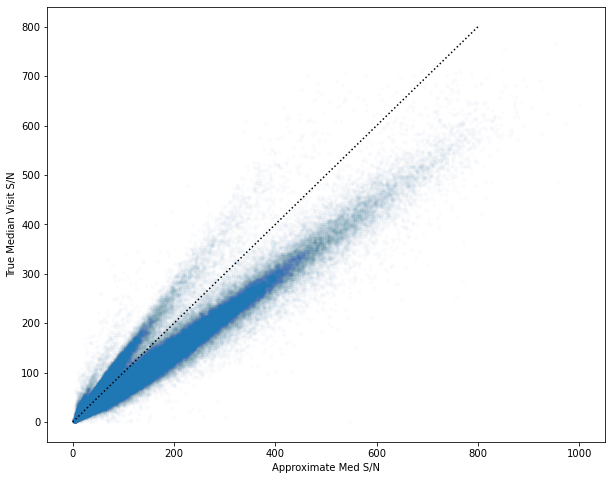

In [11]:
plt.figure(figsize=(10,8))
plt.plot(allStarSmall_tab['VISIT_MED_SNR_APPROX'],allStarSmall_tab['VISIT_MED_SNR'],'.',alpha=0.01)
plt.plot(np.linspace(0,800,10),np.linspace(0,800,10),'k:')
plt.xlabel('Approximate Med S/N')
plt.ylabel("True Median Visit S/N")
plt.show()

## Limit to only Good Stars
STARFLAG = 0
Think about ASPCAPFLAG = 0

In [12]:
allStarGood_tab = allStarSmall_tab[(allStarSmall_tab['STARFLAG'] == 0)]
allStarGood_tab

FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,"FPARAM_GRID [21,9]",CHI2_GRID [21],FPARAM [9],"FPARAM_COV [9,9]",ASPCAP_CHI2,PARAM [9],"PARAM_COV [9,9]",PARAMFLAG [9],ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM [27],FELEM_ERR [27],X_H [27],X_H_ERR [27],X_M [27],X_M_ERR [27],ELEM_CHI2 [27],ELEMFRAC [27],ELEMFLAG [27],EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC [27],X_M_SPEC [27],TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,VISIT_PK [100],VISIT_MED_SNR,VISIT_MED_SNR_APPROX
bytes64,bytes30,bytes58,bytes71,bytes77,bytes6,int32,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,bytes16,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,int64,int64,bytes256,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int64,int32,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,f

## Initial Plots

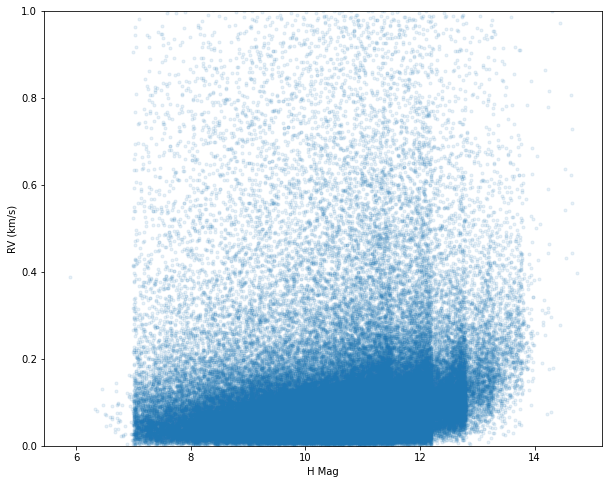

In [13]:
plt.figure(figsize=(10,8))
plt.plot(allStarGood_tab['H'],allStarGood_tab['VSCATTER'],'.',alpha=0.1)
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
plt.ylim(0,1)
plt.show()

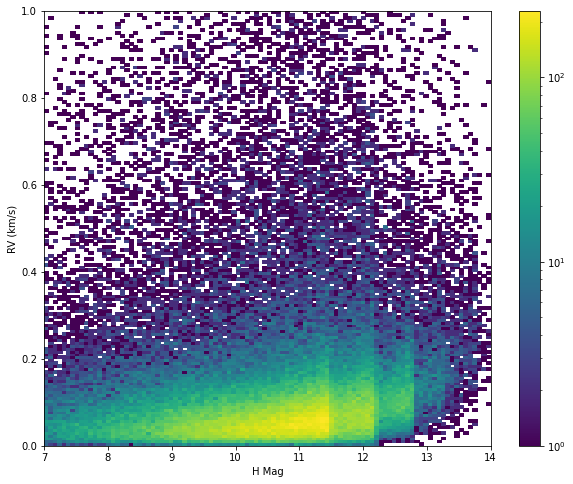

In [14]:
plt.figure(figsize=(10,8))
plt.hist2d(allStarGood_tab['H'],allStarGood_tab['VSCATTER'],bins=(100,150),range=((7,14),(0,1.0)),
           norm=mpl.colors.LogNorm())
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
#plt.yscale('log')
#plt.cscale('log')
plt.colorbar()
plt.show()

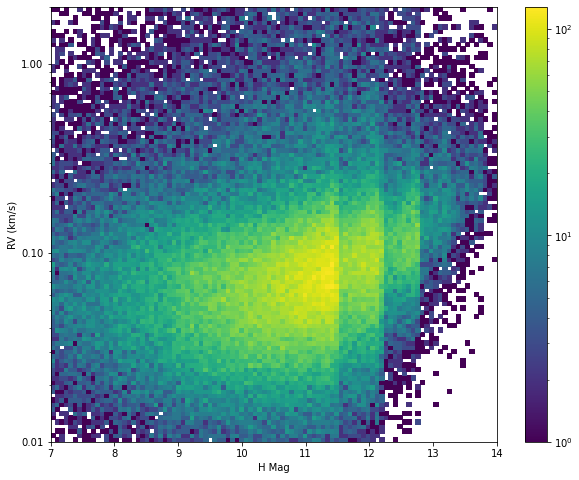

In [15]:
plt.figure(figsize=(10,8))
xbins = np.linspace(7, 14, 100)
ybins = 10**np.linspace(-2, .3, 100)
counts, _, _ = np.histogram2d(allStarGood_tab['H'],allStarGood_tab['VSCATTER'],bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
plt.yscale('log')
plt.colorbar()
plt.ylim(0.01,2)
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()

Zeropoint: 10.36 +/- 0.020


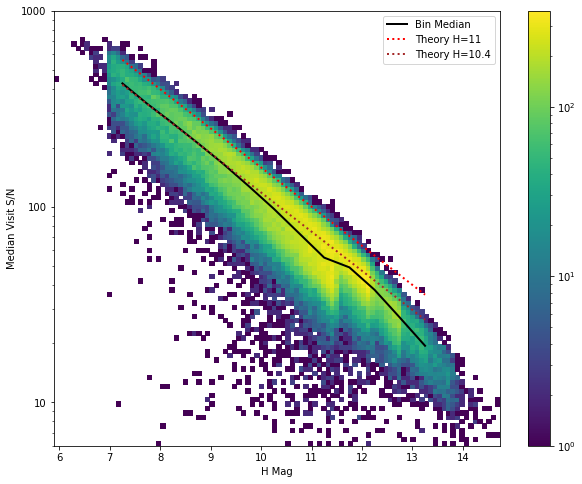

In [16]:
plt.figure(figsize=(10,8))
ybins = 10**np.linspace(np.log10(6), 3, 100)
plt.hist2d(allStarGood_tab['H'],allStarGood_tab['VISIT_MED_SNR'],bins=(100,ybins), \
           norm=mpl.colors.LogNorm())
xbins2 = np.linspace(7,13.5,14)
(median_arr,xbins2_arr,indice_arr) = stats.binned_statistic(allStarGood_tab['H'],\
                                                            allStarGood_tab['VISIT_MED_SNR'], statistic='median', \
                                                            bins=xbins2)
xbinCen_arr = (xbins2_arr[0:-1] + xbins2_arr[1:])/2
(param,cov) = curve_fit(fit_h2sn,xbinCen_arr,median_arr,p0=[11])
perr = np.sqrt(np.diag(cov))
print("Zeropoint: {:.2f} +/- {:.3f}".format(param[0],perr[0]))

plt.plot(xbinCen_arr,median_arr,lw=2,c='k', label="Bin Median")
plt.plot(xbinCen_arr,h2sn(xbinCen_arr,exptime=60),'r:',lw=2,label="Theory H=11")
plt.plot(xbinCen_arr,h2sn(xbinCen_arr,exptime=60,zeropoint=param[0]),':', c='brown',lw=2, \
         label="Theory H={:.1f}".format(param[0]))
plt.xlabel("H Mag")
plt.ylabel("Median Visit S/N")
plt.yscale('log')
plt.colorbar()
plt.legend()
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.savefig('DR17_Hvsn.png',dpi=200)
plt.show()

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]


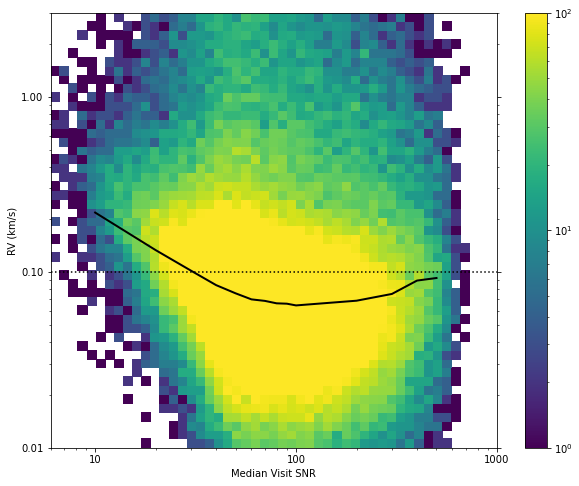

In [17]:
plt.figure(figsize=(10,8))
xbins = 10**np.linspace(np.log10(6), 3, 50)
#xbins2 = xbins[11:-2]
xbins2 = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600]
ybins = 10**np.linspace(-2,np.log10(3), 50)

(median_arr,xbins2_arr,indice_arr) = stats.binned_statistic(allStarGood_tab['VISIT_MED_SNR'],allStarGood_tab['VSCATTER'], statistic='median', \
                       bins=xbins2)
#xbinCen_arr = (xbins2_arr[0:-1] + xbins2_arr[1:])/2
xbinCen_arr = xbins2[0:-1]
print(xbinCen_arr)

counts, _, _ = np.histogram2d(allStarGood_tab['VISIT_MED_SNR'],allStarGood_tab['VSCATTER'],bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.plot(xbinCen_arr,median_arr,lw=2,c='k')
plt.xlabel("Median Visit SNR")
plt.ylabel("RV (km/s)")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.ylim(0.01,3)
plt.clim(1,100)
plt.gca().axhline(0.10,c="k",ls=":")
plt.tick_params(axis='y', which='both', left=True, right=True,labelleft=True, labelright=False)
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()

[ 2743.  7302. 12550. 16495. 14739. 11784.  9165.  7612.  6262. 30819.
  9752.  3920.  1657.   523.]


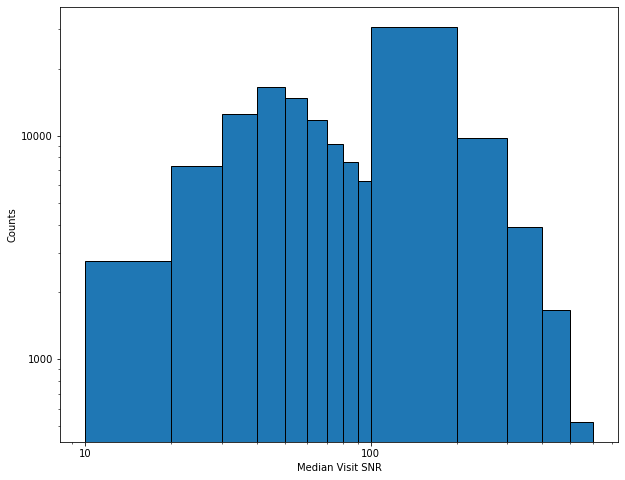

In [18]:
plt.figure(figsize=(10,8))
(counts,bins,_) = plt.hist(allStarGood_tab['VISIT_MED_SNR'],xbins2,edgecolor='k')
plt.xlabel("Median Visit SNR")
plt.ylabel("Counts")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
print(counts)

In [19]:
dr17_tab = Table()
dr17_tab['Visit_SNR'] = xbinCen_arr
dr17_tab['RV_all'] = median_arr
dr17_tab.write('dr17fit_all.fits',overwrite=True)
dr17_tab

Visit_SNR,RV_all
int64,float64
10,0.21877388656139374
20,0.13369929790496826
30,0.10207810997962952
40,0.0844573825597763
50,0.07585250586271286
60,0.07005529850721359
70,0.06867190450429916
80,0.06652209162712097
90,0.06620052456855774


## Reproduce David's plot
1. Dwarfs: log >= 4.1
2. Subgiants: 3.5 <= log g < 4.1 (or Teff >= 5000K and 3.0 <= log g <3.5)
3. Giants: log g <= 3.0 (or Teff < 5000 K and 3.0 <= log g < 3.5).

In [20]:
david_tab = allStarSmall_tab[(allStarSmall_tab['LOGG'] < 3.0) & (allStarSmall_tab['SNR']>= 20) & (allStarSmall_tab['NVISITS'] >= 3)]
david_tab

FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,"FPARAM_GRID [21,9]",CHI2_GRID [21],FPARAM [9],"FPARAM_COV [9,9]",ASPCAP_CHI2,PARAM [9],"PARAM_COV [9,9]",PARAMFLAG [9],ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM [27],FELEM_ERR [27],X_H [27],X_H_ERR [27],X_M [27],X_M_ERR [27],ELEM_CHI2 [27],ELEMFRAC [27],ELEMFLAG [27],EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC [27],X_M_SPEC [27],TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,VISIT_PK [100],VISIT_MED_SNR,VISIT_MED_SNR_APPROX
bytes64,bytes30,bytes58,bytes71,bytes77,bytes6,int32,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,bytes16,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,int64,int64,bytes256,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int64,int32,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,f

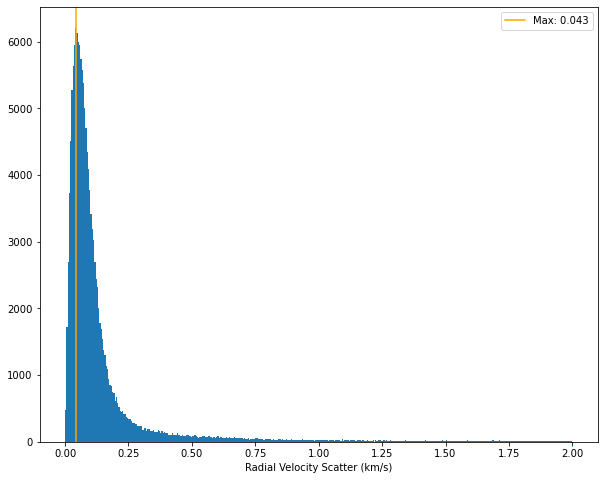

In [21]:
plt.figure(figsize=(10,8))
(counts,bins,patches) = plt.hist(david_tab['VSCATTER'],400,(0,2))
max_ind = np.argmax(counts)
max_cen = (bins[max_ind] + bins[max_ind+1]) /2
plt.gca().axvline(max_cen,c='orange',label='Max: {:0.3f}'.format(max_cen))
#plt.gca().axvline(0.1,c='k',label='0.1 km/s')
plt.xlabel("Radial Velocity Scatter (km/s)")
plt.legend()
plt.show()

In [22]:
david2_tab = allStarSmall_tab[(allStarSmall_tab['TEFF'] > 4000) & (allStarSmall_tab['TEFF'] < 4500)]
david2_tab

FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,"FPARAM_GRID [21,9]",CHI2_GRID [21],FPARAM [9],"FPARAM_COV [9,9]",ASPCAP_CHI2,PARAM [9],"PARAM_COV [9,9]",PARAMFLAG [9],ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM [27],FELEM_ERR [27],X_H [27],X_H_ERR [27],X_M [27],X_M_ERR [27],ELEM_CHI2 [27],ELEMFRAC [27],ELEMFLAG [27],EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC [27],X_M_SPEC [27],TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,VISIT_PK [100],VISIT_MED_SNR,VISIT_MED_SNR_APPROX
bytes64,bytes30,bytes58,bytes71,bytes77,bytes6,int32,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,bytes16,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,int64,int64,bytes256,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int64,int32,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,f

52098
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]
[ 2640.  4594.  5097.  4774.  4167.  3472.  2926.  2363.  2196. 12122.
  4454.  1834.   756.   170.]


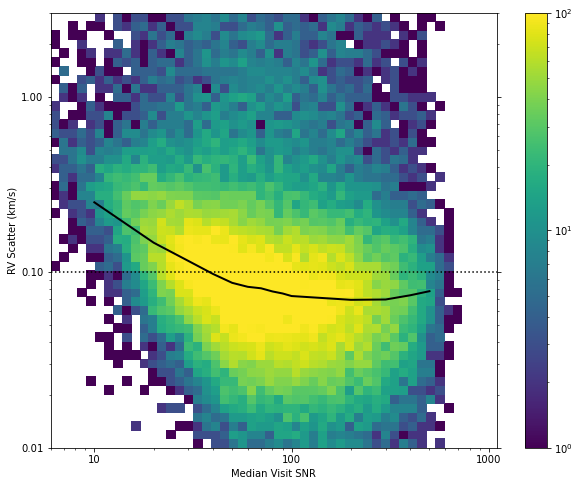

In [23]:
safe_snr_arr = david2_tab['VISIT_MED_SNR'][np.isfinite(david2_tab['VISIT_MED_SNR']) 
                                          & np.isfinite(david2_tab['VSCATTER'])] 
safe_rms_arr = david2_tab['VSCATTER'][np.isfinite(david2_tab['VISIT_MED_SNR']) 
                                          & np.isfinite(david2_tab['VSCATTER'])]
print(len(safe_snr_arr))

plt.figure(figsize=(10,8))
xbins = 10**np.linspace(np.log10(6), 3, 50)
#xbins2 = xbins[11:-2]
xbins2 = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600]
ybins = 10**np.linspace(-2,np.log10(3), 50)
xp = np.linspace(10,200)

(median_arr,xbins2_arr,indice_arr) = stats.binned_statistic(safe_snr_arr,safe_rms_arr, statistic='median', \
                       bins=xbins2)
(count_arr,_,_) = stats.binned_statistic(safe_snr_arr,safe_rms_arr, statistic='count', \
                       bins=xbins2)
#xbinCen_arr = (xbins2_arr[0:-1] + xbins2_arr[1:])/2
xbinCen_arr = xbins2[0:-1]
print(xbinCen_arr)
print(count_arr)

counts, _, _ = np.histogram2d(safe_snr_arr,safe_rms_arr,bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.plot(xbinCen_arr,median_arr,lw=2,c='k')

plt.xlabel("Median Visit SNR")
plt.ylabel("RV Scatter (km/s)")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.xlim(6,1100)
plt.ylim(0.01,3)
plt.clim(1,100)
plt.gca().axhline(0.10,c="k",ls=":")
plt.tick_params(axis='y', which='both', left=True, right=True,labelleft=True, labelright=False)
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.savefig('DR17_3visit_RVs.png',dpi=200)
plt.show()

[ 2640.  4594.  5097.  4774.  4167.  3472.  2926.  2363.  2196. 12122.
  4454.  1834.   756.   170.]


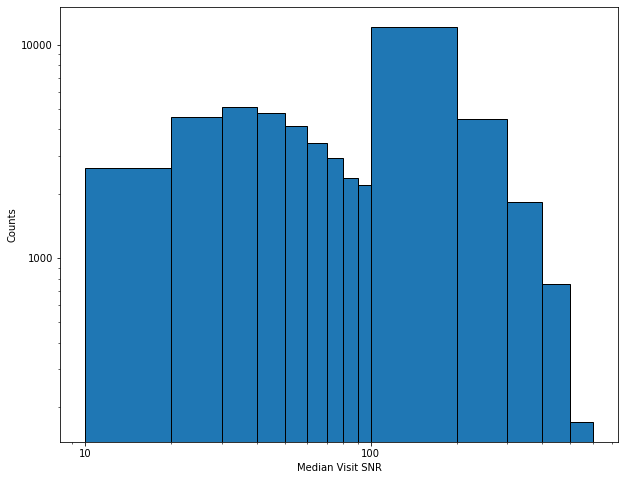

In [24]:
plt.figure(figsize=(10,8))
(counts,bins,_) = plt.hist(safe_snr_arr,xbins2,edgecolor='k')
plt.xlabel("Median Visit SNR")
plt.ylabel("Counts")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
print(counts)

## Save Analysis Results

In [25]:
dr17_tab = Table()
dr17_tab['Visit_SNR'] = xbinCen_arr
dr17_tab['RV_david'] = median_arr
dr17_tab.write('dr17fit_david.fits',overwrite=True)
dr17_tab

Visit_SNR,RV_david
int64,float64
10,0.25026026368141174
20,0.1473064422607422
30,0.11592504382133484
40,0.0977250188589096
50,0.08701131492853165
60,0.08259564638137817
70,0.08102576434612274
80,0.07773648947477341
90,0.07571017742156982
